# Lewinson Chapter 6: Monte Carlo Simulations in Finance

## Introduction

Chapter 6 of Eryk Lewinson's [*Python for Finance Cookbook*](https://www.packtpub.com/product/python-for-finance-cookbook/9781789618518) introduces simulation techniques.

We will focus on:

1. Simulating stock prices
1. Pricing European options with these simulated stock prices
1. Calculating value at risk (VaR)

***Note:*** Indented block quotes are from Lewinson, and section numbers differ from Lewinson because we will not discuss every topic.

I will simplify and streamline his code, where possible.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.rcParams['figure.dpi'] = 150
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession(expire_after='1D')

> Monte Carlo simulations are a class of computational algorithms that use repeated random sampling to solve any problems that have a probabilistic interpretation. In finance, one of the reasons they gained popularity is that they can be used to accurately estimate integrals. The main idea of Monte Carlo simulations is to produce a multitude of sample paths—possible scenarios/outcomes, often over a given period of time. The horizon is then split into a specified number of time steps and the process of doing so is called discretization. Its goal is to approximate continuous time, since the pricing of financial instruments happens in continuous time.
>
> The results from all these simulated sample paths can be used to calculate metrics such as the percentage of times an event occurred, the average value of an instrument at the last step, and so on. Historically, the main problem with the Monte Carlo approach was that it required heavy computational power to calculate all possible scenarios. Nowadays, it is becoming less of a problem as we can run fairly advanced simulations on a desktop computer or a laptop.

## Simulating stock price dynamics using Geometric Brownian Motion

> Thanks to the unpredictability of financial markets, simulating stock prices plays an important role in the valuation of many derivatives, such as options. Due to the aforementioned randomness in price movement, these simulations rely on stochastic differential equations (SDE).
> 
> A stochastic process is said to follow the Geometric Brownian Motion (GBM) when it satisfies the following SDE: $$dS = \mu S dt + \sigma S dW_t$$
> 
> Here, we have the following:
> 
> - $S$: Stock price
> - $\mu$: The drift coefficient, that is, the average return over a given period or the instantaneous expected return
> - $\sigma$: The diffusion coefficient, that is, how much volatility is in the drift
> - $W_t$: The Brownian Motion
> 
> We will not investigate the properties of the Brownian Motion in too much depth, as it is outside the scope of this book. Suffice to say, Brownian increments are calculated as a product of a Standard Normal random variable ($rv ∼ N(0,1)$) and the square root of the time increment. Another way to say this is that the Brownian increment comes from $rv ∼ N(0,t)$, where $t$ is the time increment. We obtain the Brownian path by taking the cumulative sum of the Brownian increments.
> 
> The SDE has a closed-form solution (only a few SDEs have it): $$S(t) = S_0 \exp\left(\left(\mu - \frac{1}{2}\sigma^2\right)t + \sigma W_t\right)$$
> 
> Here, $S_0 = S(0)$ is the initial value of the process, which in this case is the initial price of a stock. The preceding equation presents the relationship compared to the initial stock price.
> 
> For simulations, we can use the following recursive formula: $$S(t_{i+1}) = S(t_i) \exp\left(\left(\mu - \frac{1}{2}\sigma^2\right)(t_{i+1} - t_i) + \sigma \sqrt{t_{i+1} - t_i} Z_{i+1}\right)$$
> 
> Here, $Z_i$ is a Standard Normal random variable and $i = 0, \ldots, T-1$ is the time index. This specification is possible because the increments of W are independent and normally distributed.
> 
> *GBM is a process that does not account for mean-reversion and time-dependent volatility. That is why it is often used for stocks and not for bond prices, which tend to display long-term reversion to the face value.*

In [4]:
df = yf.download(tickers='MSFT', session=session)
df['Return'] = df['Adj Close'].pct_change()
returns = df.loc['2019', 'Return']

[*********************100%***********************]  1 of 1 completed

We will use the first ten months to "train" and the last two months to "test".

In [5]:
train = returns[:'2019-10-31']
test = returns['2019-11-01':]

We will use the training sample to estimate parameters, like $\mu$ and $\sigma$.

In [6]:
T = len(test)
N = len(test)
S_0 = df.loc[train.index[-1], 'Adj Close']
N_SIM = 100
mu = train.mean()
sigma = train.std()

We will use Lewinson's `simulate_gbm()` function for simulations.

In [7]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)
    
    dt = T / N
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    
    return S_t

Next, we run the simulations.

In [8]:
np.random.seed(42)
gbm_simulations = pd.DataFrame(
    data=simulate_gbm(S_0, mu, sigma, N_SIM, T, N).T,
    index=returns.loc[train.index[-1]:].index,
    columns=pd.Index(data=range(1, N_SIM + 1), name='Simulation')
)

Finally, plot the simulation results.

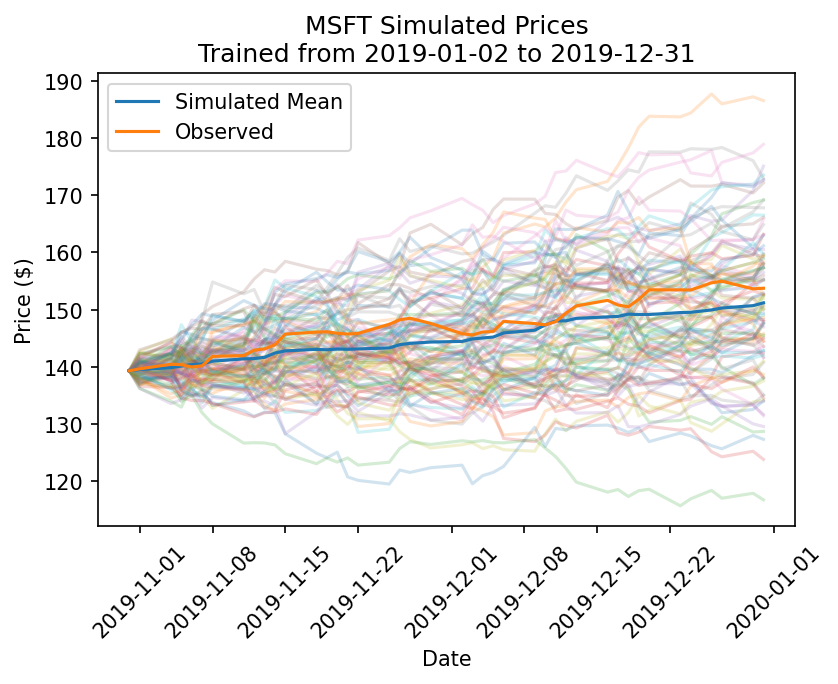

In [9]:
plt.plot(gbm_simulations, alpha=0.2, label='_nolegend_') # use plt.plot to omit lines from legend
plt.plot(gbm_simulations.mean(axis=1), label='Simulated Mean')
plt.plot(df.loc[gbm_simulations.index, 'Adj Close'], label='Observed')
plt.legend()
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.xticks(rotation=45) # but plt.plot() does not provide smart ticks
plt.title(
    'MSFT Simulated Prices\n' + 
    'Trained from {} to {}'.format(returns.index[0].strftime('%Y-%m-%d'), returns.index[-1].strftime('%Y-%m-%d'))
)
plt.show()

The average simulation is very close to the observed truth!
The *average* average simulation should be close to the *average* observed truth (if the training period is similar to the test period).
However, this will not always be true.
We will repeat the exercise above for 2018 to see that average simulation predicts the truth on average (if the training period is similar to the test period) but does not predict every future.

## Pricing European Options using Simulations 

> Options are a type of derivative instrument because their price is linked to the price of the underlying security, such as stock. Buying an options contract grants the right, but not the obligation, to buy or sell an underlying asset at a set price (known as a strike) on/before a certain date. The main reason for the popularity of options is because they hedge away exposure to an asset's price moving in an undesirable way.
> 
> A European call/put option gives us the right (but again, no obligation) to buy/sell a certain asset on a certain expiry date (commonly denoted as $T$).
> 
> Some popular methods of options' valuation:
> 
> - Using analytic formulas
> - Binomial tree approach
> - Finite differences
> - Monte Carlo simulations
>
> European options are an exception in the sense that there exist an analytical formula for their valuation, which is not the case for more advanced derivatives, such as American or Exotic options.
> 
> To price options using Monte Carlo simulations, we use risk-neutral valuation, under which the fair value of a derivative is the expected value of its future payoff(s). In other words, we assume that the option premium grows at the same rate as the risk-free rate, which we use for discounting to the present value. For each of the simulated paths, we calculate the option's payoff at maturity, take the average of all the paths, and discount it to the present value.
> 
> In this recipe, we show how to code the closed-form solution to the Black-Scholes model and then use the simulation approach. For simplicity, we use fictitious input data, but real-life data could be used analogically.

We will use `norm()` from SciPy to estimate cumulative distribution functions.

In [10]:
from scipy.stats import norm

We will use Lewinson's parameters.

In [11]:
S_0 = 100
K = 100
r = 0.05
sigma = 0.50
T = 1 # 1 year
N = 252 # 252 days in a year
dt = T / N # time step
N_SIMS = 1000000 # number of simulations 
discount_factor = np.exp(-r * T)

There is an analytical solution to European options (i.e., the Black and Scholes (1973) formula).

In [12]:
def black_scholes_analytical(S_0, K, T, r, sigma, type='call'):
    '''
    Function used for calculating the price of European options using the analytical form of the Black-Scholes model.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    type : str
        Type of the option. Allowable: ['call', 'put']
    
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using the Black-Scholes model
    '''
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if type == 'call':
        val = (S_0 * norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * norm.cdf(d2, 0, 1))
    elif type == 'put':
        val = (K * np.exp(-r * T) * norm.cdf(-d2, 0, 1) - S_0 * norm.cdf(-d1, 0, 1))
    else:
        raise ValueError('Wrong input for type!')
        
    return val

We can use `black_scholes_analytical()` to value European call and put options with the parameters above.

In [13]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='call')

21.7926

We can also use `simulate_gbm()` to simulate multiple price paths, then:

1. Calculate the expected payoff as $max(S_T - K, 0)$
1. Discount the expected payoff to $t=0$ using the risk-free rate

In [14]:
gbm_simulations_2 = pd.DataFrame(simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=N_SIMS, T=T, N=N).T)

What is the payoff of a European option?
$$max(S_T - K, 0)$$

In [15]:
gbm_simulations_2.iloc[-1].sub(K).pipe(np.maximum, 0).mean() * discount_factor

21.7319

These two answers are very similar because they rely on the same assumptions:

1. risk neutrality 
1. returns that are fully described by $\mu$ and $\sigma$

Lewinson points out that we only need to simulate prices at expiration for European options.
That is, we can set `N = 1` in `simulate_gbm()`.
We will skip this exercise to save time, but you may want to review this exercise after class.

We will skip pricing American options, because this is not a derivatives class.
However, you may want to review this section after we finish this course.

## Estimating Value-at-Risk using Monte Carlo

> Value-at-risk is a very important financial metric that measures the risk associated with a position, portfolio, and so on. It is commonly abbreviated to VaR, not to be confused with Vector Autoregression. VaR reports the worst expected loss – at a given level of confidence – over a certain horizon under normal market conditions. The easiest way to understand it is by looking at an example. Let's say that the 1-day 95% VaR of our portfolio is \\$100. This means that 95\% of the time (under normal market conditions), we will not lose more than \\$100 by holding our portfolio over one day.
It is common to present the loss given by VaR as a positive (absolute) value. That is why in this example, a VaR of \\$100 means losing no more than $100.
>
>There are several ways to calculate VaR, some of which are:
>
> - Parametric Approach (Variance-Covariance)
> - Historical Simulation Approach
> - Monte Carlo simulations
>
> In this recipe, we only consider the last method. We assume that we are holding a portfolio consisting of two assets (Facebook and Google) and that we want to calculate a 1-day value-at-risk.

We will follow Lewinson's approach and set a handful of parameters in the following code cell.

In [16]:
RISKY_ASSETS = ['GOOG', 'META']
SHARES = [5, 5]
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
T = 1
N_SIMS = 10 ** 5

However, we will download all data from Yahoo! Finance, and use the start and end dates to subset our data later.

In [17]:
df = yf.download(tickers=RISKY_ASSETS, session=session)

[                       0%                       ]

[*********************100%***********************]  2 of 2 completed

Next, we calculate daily returns.

In [18]:
returns = df['Adj Close'].pct_change().loc[START_DATE:END_DATE]

We will need the variance-covariance matrix.

In [19]:
cov_mat = returns.cov()

In [20]:
cov_mat

,GOOG,META
GOOG,0.0003,0.0003
META,0.0003,0.0006


We will use the variance-covariance matrix to calculate the Cholesky decomposition.

In [21]:
chol_mat = np.linalg.cholesky(cov_mat)

In [22]:
chol_mat

array([[0.0177, 0.    ],
       [0.015 , 0.0187]])

The Cholesky decomposition helps us generate random variables with the same variance and covariance as the observed data.

In [23]:
rv = np.random.normal(size=(N_SIMS, len(RISKY_ASSETS)))

In [24]:
correlated_rv = (chol_mat @ rv.T).T

These random variables have a variance-covariance matrix similar to the real data.

In [25]:
np.cov(correlated_rv.T)

array([[0.0003, 0.0003],
       [0.0003, 0.0006]])

Here are the parameters for the simulated price paths:

In [26]:
r = returns.mean().values
sigma = returns.std().values
S_0 = df['Adj Close'].iloc[-1].values
P_0 = np.sum(SHARES * S_0)

Calculate terminal prices:

In [27]:
S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * correlated_rv)

In [28]:
S_T

array([[110.5353, 165.1166],
       [110.5998, 165.3186],
       [110.5804, 165.2636],
       ...,
       [110.512 , 165.0904],
       [110.5198, 165.0408],
       [110.5044, 165.0648]])

Calculate terminal portfolio values and returns.
Note that these are dollar values, since VaR is typically expressed in dollar values.

In [29]:
P_T = np.sum(SHARES * S_T, axis=1)

In [30]:
P_T

array([1378.2599, 1379.5917, 1379.2201, ..., 1378.0123, 1377.8029,
       1377.8458])

In [31]:
P_diff = P_T - P_0

In [32]:
P_diff

array([-1.2901,  0.0417, -0.33  , ..., -1.5377, -1.7471, -1.7042])

Next, we calculate VaR.

In [33]:
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff, percentiles)

for x, y in zip(percentiles, var):
    print(f'1-day VaR with {100-x}% confidence: ${-y:.2f}')

1-day VaR with 99.99% confidence: $3.19
1-day VaR with 99.9% confidence: $2.81
1-day VaR with 99.0% confidence: $2.38


Finally, we will plot VaR:

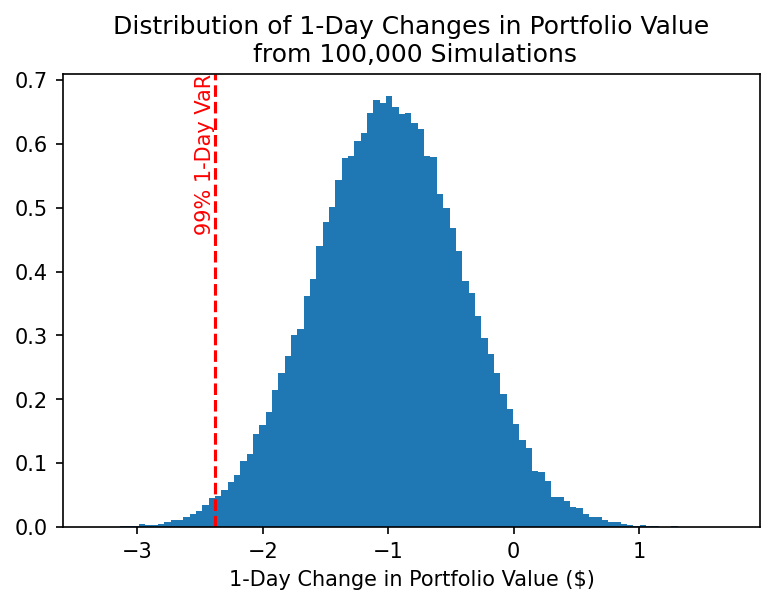

In [34]:
fig, ax = plt.subplots()
ax.hist(P_diff, bins=100, density=True)
ax.set_title('Distribution of 1-Day Changes in Portfolio Value\n from ' + format(N_SIMS, ',') + ' Simulations')
ax.axvline(x=var[2], color='red', ls='--')
ax.text(x=var[2], y=1, s='99% 1-Day VaR', color='red', ha='right', va='top', rotation=90, transform=ax.get_xaxis_transform())
ax.set_xlabel('1-Day Change in Portfolio Value ($)')
plt.show()